In [1]:
import sys

## Update this to have the path to extreme-deconvolution's python library

In [2]:
import lib.toy_data as toy_data
import lib.utils as utils
from lib.visualize_flow import visualize_transform
import lib.layers.odefunc as odefunc

from train_misc import standard_normal_logprob
from train_misc import set_cnf_options, count_nfe, count_parameters, count_total_time
from train_misc import add_spectral_norm, spectral_norm_power_iteration
from train_misc import create_regularization_fns, get_regularization, append_regularization_to_log
from train_misc import build_model_tabular

In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

import pandas as pd
import numpy as np

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
raw_np = np.load('quick_isochrone.npy')
raw_np = raw_np

raw = pd.DataFrame({'G': raw_np[:, 0], 'bp_rp': raw_np[:, 1]})

#Add some noise:

raw['g_std'] = np.random.rand(len(raw))*0.3 + 1e-3
raw['bp_rp_p'] = raw['bp_rp'] + raw['g_std']*np.random.randn(len(raw))
raw['G_p'] = raw['G'] + raw['g_std']*np.random.randn(len(raw))


In [5]:
N = len(raw)
N

100000

In [6]:
use_cols = ['G_p', 'bp_rp_p', 'g_std']#, 'BP', 'RP']
cond_cols = []

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

npdata = np.array(raw[use_cols + cond_cols])
ss.fit(npdata)
data = torch.from_numpy(npdata.astype(np.float32))

In [7]:
raw[use_cols + cond_cols].describe()

,G_p,bp_rp_p,g_std
count,100000.000000,100000.000000,100000.000000
mean,3.450007,0.105301,0.151111
std,1.309002,0.297989,0.086646
min,-4.440531,-1.196863,0.001001
25%,2.624724,-0.113673,0.075924
50%,3.713574,0.119144,0.150977
75%,4.496365,0.300695,0.226410
max,6.686640,3.255981,0.300996


In [8]:
traindataset = TensorDataset(data[:-(N//5)])
testdataset = TensorDataset(data[-(N//5):])
batch = 1024
train = DataLoader(traindataset, batch_size=batch, shuffle=True, drop_last=True)
test = DataLoader(testdataset, batch_size=batch, shuffle=False)

In [9]:
len(traindataset)/batch

78.125

In [10]:
from matplotlib import pyplot as plt

In [11]:
import pickle as pkl

In [12]:
args = pkl.load(open('args.pkl', 'rb'))

In [19]:
regularization_fns, regularization_coeffs = create_regularization_fns(args)
model = build_model_tabular(args, 2, regularization_fns).to(device)#.cuda()

In [14]:
if args.spectral_norm: add_spectral_norm(model)
set_cnf_options(args, model)

In [15]:
from torch import optim

In [16]:
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

In [20]:
transform_scale = torch.from_numpy(ss.scale_).float().to(device)[np.newaxis, :2]
transform_mean = torch.from_numpy(ss.mean_).float().to(device)[np.newaxis, :2]

def compute_loss(args, model, X, batch_size=None):
    if batch_size is None: batch_size = args.batch_size
    X = X.cuda()
    _Xerr = X[:, [2]]
    X = X[:, :2]
    X = X + torch.randn(*X.shape).cuda()*_Xerr[:, [0, 0]]

    x = (X-transform_mean)/transform_scale
#     return X
    # load data
#     x = toy_data.inf_train_gen(args.data, batch_size=batch_size)
#     x = torch.from_numpy(x).type(torch.float32).to(device)
    zero = torch.zeros(x.shape[0], 1).to(x)

    # transform to z
    z, delta_logp = model(x, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx/_Xerr**2)
    return loss

In [21]:
from lib import utils

In [22]:
import time

In [23]:
time_meter = utils.RunningAverageMeter(0.93)
loss_meter = utils.RunningAverageMeter(0.93)
nfef_meter = utils.RunningAverageMeter(0.93)
nfeb_meter = utils.RunningAverageMeter(0.93)
tt_meter = utils.RunningAverageMeter(0.93)

In [49]:
model.load_state_dict(
    torch.load('demo_model_ode_flow_v9.pt')
);

In [25]:
itr = 0

In [26]:
model = model.to(device) #cuda()
model.train();

# You can skip this:

In [181]:
end = time.time()

while itr < 10000:

    for (X,) in train:
        optimizer.zero_grad()

        if args.spectral_norm: spectral_norm_power_iteration(model, 1)

        loss = compute_loss(args, model, X)

        loss_meter.update(loss.item())
        total_time = count_total_time(model)
        nfe_forward = count_nfe(model)
        loss.backward()
        optimizer.step()

        itr += 1

        if itr % 50 == 0:
            nfe_total = count_nfe(model)
            nfe_backward = nfe_total - nfe_forward
            nfef_meter.update(nfe_forward)
            nfeb_meter.update(nfe_backward)

            time_meter.update(time.time() - end)
            tt_meter.update(total_time)

            log_message = (
                'Iter {:04d} | Time {:.4f}({:.4f}) | Loss {:.6f}({:.6f}) | NFE Forward {:.0f}({:.1f})'
                ' | NFE Backward {:.0f}({:.1f}) | CNF Time {:.4f}({:.4f})'.format(
                    itr, time_meter.val, time_meter.avg, loss_meter.val, loss_meter.avg, nfef_meter.val, nfef_meter.avg,
                    nfeb_meter.val, nfeb_meter.avg, tt_meter.val, tt_meter.avg
                )
            )
            print(log_message)

Iter 9050 | Time 6.7040(363.5875) | Loss 3273.018799(2713.182990) | NFE Forward 50(54.8) | NFE Backward 57(57.4) | CNF Time 0.5000(0.5000)
Iter 9100 | Time 43.0567(341.1503) | Loss 2771.172363(2337.272430) | NFE Forward 56(54.9) | NFE Backward 57(57.4) | CNF Time 0.5000(0.5000)
Iter 9150 | Time 80.1062(322.8772) | Loss 4820.059570(2919.115899) | NFE Forward 56(54.9) | NFE Backward 63(57.8) | CNF Time 0.5000(0.5000)
Iter 9200 | Time 117.2734(308.4850) | Loss 1171.560669(2295.947064) | NFE Forward 56(55.0) | NFE Backward 57(57.8) | CNF Time 0.5000(0.5000)
Iter 9250 | Time 154.0932(297.6775) | Loss 5607.152832(3025.931270) | NFE Forward 56(55.1) | NFE Backward 57(57.7) | CNF Time 0.5000(0.5000)
Iter 9300 | Time 190.6801(290.1877) | Loss 2057.475098(2223.106653) | NFE Forward 56(55.1) | NFE Backward 57(57.7) | CNF Time 0.5000(0.5000)
Iter 9350 | Time 226.9266(285.7594) | Loss 270.554871(2393.852262) | NFE Forward 56(55.2) | NFE Backward 57(57.6) | CNF Time 0.5000(0.5000)
Iter 9400 | Time 2

KeyboardInterrupt: 

In [29]:
# torch.save(model.cpu().state_dict(), open('demo_model_ode_flow_v9.pt', 'wb'))

# model.cpu();

In [27]:
from matplotlib import pyplot as plt

In [28]:
ss.mean_, ss.scale_

(array([3.45000656, 0.10530103, 0.15111113]),
 array([1.30899574, 0.29798791, 0.0866451 ]))

In [29]:
model = model.cpu()
#model.eval();

In [30]:
from torch.functional import F

In [101]:
pdata.shape

torch.Size([10000, 3])

In [34]:
def ezmodel(model, x):
    zero = torch.zeros(x.shape[0], 1)
    # transform to z
    z, delta_logp = model(x, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    
    return logpx

def soft_lo_clamp(x, lo):
    return F.softplus(x-lo) + lo

# for age in np.linspace(9.1, 9.9, num=10):
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5*2, 5*2))
# ax = ax.ravel()
model#.cuda()
minG = -2#np.percentile(raw['G'], 3)
maxG = 5#np.percentile(raw['G'], 100-3)
minbprp = -0.5#np.percentile(raw['bp_rp'], 3)
maxbprp = 1#np.percentile(raw['bp_rp'], 100-3)
num = 100
pG, pbprp = np.meshgrid(np.linspace(minG, maxG, num=num), np.linspace(minbprp, maxbprp, num=num))
pG = pG.reshape(-1)
pbprp = pbprp.reshape(-1)

pdatap = np.zeros((len(pG), len(use_cols) + len(cond_cols)), dtype=np.float32)
pdatap[:, 0] = pG
pdatap[:, 1] = pbprp

pdata = ss.transform(pdatap)

pdata = torch.from_numpy(pdata)#.cuda()
pdata_set = TensorDataset(pdata)
pdata_loader = DataLoader(pdata_set, batch_size=1000, shuffle=False)
model.eval()
logprob = soft_lo_clamp(torch.cat([ezmodel(model, q[:, :2]).cpu().detach() for (q,) in pdata_loader], dim=0), -100).numpy()
#logprob_xd = soft_lo_clamp(
#    torch.from_numpy(np.log(np.exp(xd.logprob_a(pdatap[:, [1, 0]], 0.0*np.eye(2)[np.newaxis]*np.ones(len(pdatap[:]))[:, None, None])).sum(1))), -100).numpy()

_exp = lambda _x: np.exp(_x/4)
#prob_xd = _exp(logprob_xd.reshape(num, num))
prob = _exp(logprob.reshape(num, num))

/Users/landerson/AstroHackWeek2020/xd_vs_flow/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


In [35]:
import matplotlib as mpl

In [40]:
import torch

In [43]:
torch.autograd.grad?

In [44]:
model.parameters()

<generator object Module.parameters at 0x1a33b3d650>

In [ ]:
def ezmodel(model, x):
    zero = torch.zeros(x.shape[0], 1)
    # transform to z
    z, delta_logp = model(x, zero)
    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)
    logpx = logpz - delta_logp
    return logpx

In [173]:
class Objective(nn.Module):
    def __init__(self, model, x):
        super(Objective, self).__init__()
        self.x = nn.Parameter(x, requires_grad=True)
        #self.model = model.requires_grad_(True)
        
    def forward(self, foo=None):
        return -1.*self.lnprob()
    
    def lnprob(self):
        #self.model.eval()
        zeros = torch.zeros(self.x.shape[0], 1)
        z, delta_logp = model(self.x, zeros)
        logpz = standard_normal_logprob(z).sum(1, keepdim=True)
        logpx = logpz - delta_logp
        #pdata = torch.Tensor([self.x], device=device).unsqueeze(1)#.t()
        return logpx

In [174]:
x = torch.Tensor(np.array([1,1]), device=device).unsqueeze(1).t()
zeros = torch.zeros(2, 1)

In [231]:
minG = -2#np.percentile(raw['G'], 3)
maxG = 5#np.percentile(raw['G'], 100-3)
minbprp = -0.5#np.percentile(raw['bp_rp'], 3)
maxbprp = 1#np.percentile(raw['bp_rp'], 100-3)
num = 40
xM = np.linspace(minG, maxG, num=num)
xc = np.linspace(minbprp, maxbprp, num=num)
pG, pbprp = np.meshgrid(xM, xc)
pG = pG.reshape(-1)
pbprp = pbprp.reshape(-1)

pdatap = np.zeros((len(pG), len(use_cols) + len(cond_cols)), dtype=np.float32)
pdatap[:, 0] = pG
pdatap[:, 1] = pbprp

pdata = ss.transform(pdatap)

pdata = torch.from_numpy(pdata)#.cuda()
pdata_set = TensorDataset(pdata)
pdata_loader = DataLoader(pdata_set, batch_size=1000, shuffle=False)
model.eval()
 
logprob = soft_lo_clamp(torch.cat([ezmodel(model, q[:, :2]).cpu().detach() for (q,) in pdata_loader], dim=0), -100).numpy()
_exp = lambda _x: np.exp(_x/4)
#prob_xd = _exp(logprob_xd.reshape(num, num))
prob = _exp(logprob.reshape(num, num))

/Users/landerson/AstroHackWeek2020/xd_vs_flow/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


In [232]:
grads = np.zeros((pdata.shape[0], pdata.shape[1]-1))
for i, q in enumerate(pdata):
    #print(q.shape)
    obj = Objective(model, q[:2].unsqueeze(1).t())
    o = obj()
    o.backward()
    for name, p in obj.named_parameters():
        if name == 'x': grads[i,:] = p.grad.data.numpy()


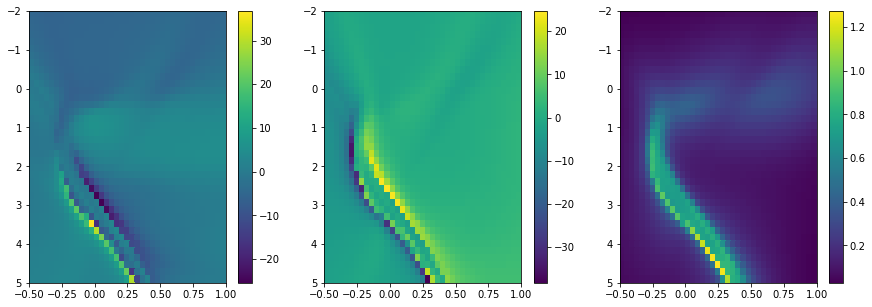

In [233]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
titles = ['grad M', 'grad c', 'prob']
for i, a in enumerate(ax[0:2]):
    im = a.pcolormesh(xc, xM, grads.reshape(num, num, 2)[:,:,i].T)
    plt.colorbar(im, ax=a)
im = ax[2].pcolormesh(xc, xM, prob.T)#, cmap='jet')
plt.colorbar(im, ax=ax[2])
for a, t in zip(ax, titles):
    a.invert_yaxis()
    a.set_xlabel('BP-RP')
    a.set_ylabel('G')
    a.set_title(t)

In [181]:
from hessian import hessian

In [234]:
hessian(o, obj.parameters())

AssertionError: 

In [237]:
torch.autograd.functional.hessian(obj, torch.zeros(1))

tensor([[0.]])

In [53]:
torch.Tensor([0.1, 0.1]).unsqueeze(1).t().shape

torch.Size([1, 2])

In [61]:
def cache(self, x):
    # unpack x and load into module 
    state_dict = self.unpack_parameters(x)
    self.f.load_state_dict(state_dict)
    # store the raw array as well
    self.cached_x = x
    # zero the gradient
    self.f.zero_grad()
    # use it to calculate the objective
    obj = self.f()
    # backprop the objective
    obj.backward()
    self.cached_f = obj.item()
    self.cached_jac = self.pack_grads()
    self.cached_hes = hessian(self.f(), self.f.parameters())

obj.zero_grad()
o = obj()
o.backward()
grads = []
for p in obj.parameters():
    print(p, p.grad)
    #import pdb; pdb.set_trace()
    grad = p.grad.data.numpy()
    grads.append(grad.ravel())
grads = np.concatenate(grads)

/Users/landerson/AstroHackWeek2020/xd_vs_flow/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


RuntimeError: grad can be implicitly created only for scalar outputs

In [36]:
from matplotlib.colors import Normalize

class CustomNorm(Normalize):
    def __init__(self, alpha, clip=False):
        # input levels
        self.alpha = alpha
        # corresponding normalized values between 0 and 1
        Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return (value/value.max())**self.alpha#(np.log10((value)+1e-10)+10)/10/1.013 

    def inverse(self, value):
        return 1.0 - self.__call__(value)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  import sys


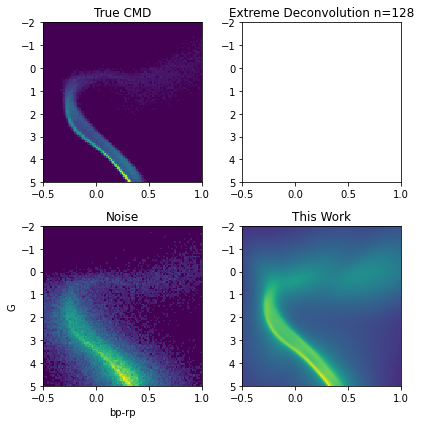

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(2*3, 2*3))
ax = ax.ravel()
norm = CustomNorm(0.5)
# ax[0].scatter(*np.array(raw[['bp_rp', 'G']]).T, s=0.1, alpha=0.1)
h, _, _, _ = ax[0].hist2d(raw['bp_rp'], raw['G'], bins=100, range=[(minbprp, maxbprp), (minG, maxG)], norm=norm, normed=True)
ax[0].set_title('True CMD')
ax[2].hist2d(raw['bp_rp_p'], raw['G_p'], bins=100, range=[(minbprp, maxbprp), (minG, maxG)], norm=norm, normed=True)
ax[2].set_title('Noise')
# plotXdgmm(xd, ax[1])


cax = ax[1]
#cax.imshow(prob_xd.T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
cax.set_title('Extreme Deconvolution n=128')
cax = ax[3]
cax.imshow(prob.T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
cax.set_title('This Work')
# cax = ax[5]
# cax.imshow(np.abs(prob-h).T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
# cax.set_title('Absolute Residual')
# cax = ax[2]
# cax.imshow(np.abs(prob_xd-h).T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
# cax.set_title('Absolute Residual')

# cax.cbar()
ax[2].set_ylabel('G')
ax[2].set_xlabel('bp-rp')
for i in range(4):
    ax[i].set_ylim(5, -2)
    ax[i].set_xlim(minbprp, maxbprp)
# cax.set_title('feh_std=%f' % (feh_std,))

plt.tight_layout()
plt.savefig('t1.png', dpi=150)